In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, sys, datetime as dt, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Load Dataset

In [3]:
df_raw = pd.read_csv('new_jan_1.csv')
df_raw.head()

,taxi_id,trip_seconds,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_minuate,trip_km
0,85.0,180.0,4.50,0.0,0.0,0.0,4.50,199.0,510.0,199.0,510.0,3.0,0.643700
1,4237.0,480.0,7.00,0.0,0.0,0.0,7.00,686.0,500.0,686.0,500.0,8.0,1.770300
2,1987.0,1080.0,17.75,0.0,0.0,0.0,17.75,599.0,346.0,660.0,120.0,18.0,9.977900
3,6400.0,60.0,3.75,0.0,0.0,0.0,3.75,527.0,24.0,527.0,24.0,1.0,0.321900
4,7418.0,180.0,5.00,2.0,0.0,1.5,8.50,210.0,470.0,744.0,605.0,3.0,1.001646


In [4]:
df = df_raw.copy()

# EDA

#### Missing Values

In [5]:
df.isnull().sum()

taxi_id              0
trip_seconds         0
fare                 0
tips                 0
tolls                0
extras               0
trip_total           0
pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
trip_minuate         0
trip_km              0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384038 entries, 0 to 1384037
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   taxi_id            1384038 non-null  float64
 1   trip_seconds       1384038 non-null  float64
 2   fare               1384038 non-null  float64
 3   tips               1384038 non-null  float64
 4   tolls              1384038 non-null  float64
 5   extras             1384038 non-null  float64
 6   trip_total         1384038 non-null  float64
 7   pickup_latitude    1384038 non-null  float64
 8   pickup_longitude   1384038 non-null  float64
 9   dropoff_latitude   1384038 non-null  float64
 10  dropoff_longitude  1384038 non-null  float64
 11  trip_minuate       1384038 non-null  float64
 12  trip_km            1384038 non-null  float64
dtypes: float64(13)
memory usage: 137.3 MB


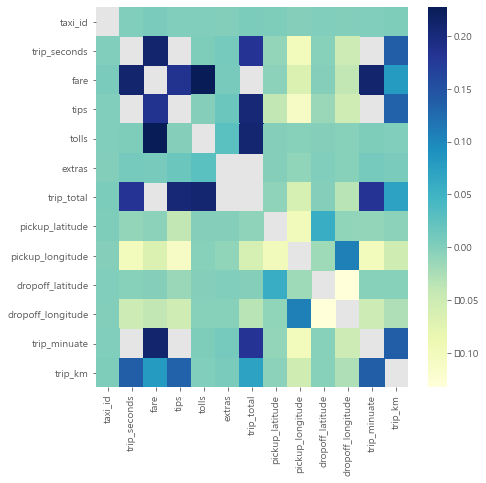

In [7]:
plt.figure(figsize=(7,7))
mask=df.corr() > 0.3
sns.heatmap(df.corr(),cmap='YlGnBu',mask=mask,fmt='.1g')

# Data Preprocessing

In [8]:
df.columns

Index(['taxi_id', 'trip_seconds', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'trip_minuate', 'trip_km'],
      dtype='object')

In [9]:
# 불필요 변수 삭제

data = df[['trip_seconds', 'fare', 'tips', 'tolls', 'extras', 'trip_km', 'trip_total']]

X_cols = list(data.columns)
X_cols.remove('trip_total')

In [10]:
X_cols

['trip_seconds', 'fare', 'tips', 'tolls', 'extras', 'trip_km']

In [11]:
X = data[X_cols]
y = data['trip_total']

In [12]:
# Scaling

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
#y = y_scaler.fit_transform(y.values.reshape(-1,1))

In [13]:
# Train, Test splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [14]:
print('Train Set : ', X_train.shape)
print('Test Set : ', X_test.shape)

Train Set :  (968826, 6)
Test Set :  (415212, 6)


# Create Base Model

### Light Gradient Boosting Machine

In [15]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [16]:
params = {
            'learning_rate' : 0.01,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [17]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 38.3006
[200]	valid_0's rmse: 33.075
[300]	valid_0's rmse: 31.754
[400]	valid_0's rmse: 31.5454
[500]	valid_0's rmse: 31.3797
[600]	valid_0's rmse: 31.179
[700]	valid_0's rmse: 31.0898
[800]	valid_0's rmse: 31.0544
[900]	valid_0's rmse: 31.0197
Early stopping, best iteration is:
[850]	valid_0's rmse: 31.0036


In [18]:
# 예측
pred = model.predict(X_test)

In [19]:
pred

array([59.24145091,  5.75849678, 20.19422167, ...,  6.75052477,
        6.90063717,  8.27537194])

In [20]:
np.sqrt(mean_squared_error(y_test,pred))

31.003584747408226

In [21]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    model.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    model.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
lgb_predict = X_train_predict.append(X_test_predict)

In [22]:
lgb_predict[:5]

,predict
0,11.484291
1,10.480989
2,6.523720
3,16.457751
4,10.696893


In [23]:
data['lgb_predict'] = lgb_predict.values

In [24]:
data

,trip_seconds,fare,tips,tolls,extras,trip_km,trip_total,lgb_predict
0,180.0,4.50,0.00,0.0,0.0,0.643700,4.50,11.484291
1,480.0,7.00,0.00,0.0,0.0,1.770300,7.00,10.480989
2,1080.0,17.75,0.00,0.0,0.0,9.977900,17.75,6.523720
3,60.0,3.75,0.00,0.0,0.0,0.321900,3.75,16.457751
4,180.0,5.00,2.00,0.0,1.5,1.001646,8.50,10.696893
...,...,...,...,...,...,...,...,...
1384033,540.0,12.25,2.45,0.0,0.0,0.321900,14.70,6.523367
1384034,840.0,10.25,0.00,0.0,0.0,3.862400,10.25,7.503609
1384035,1380.0,44.00,5.00,0.0,0.0,28.807300,49.00,6.750525
1384036,960.0,11.75,0.00,0.0,1.0,4.023400,12.75,6.900637


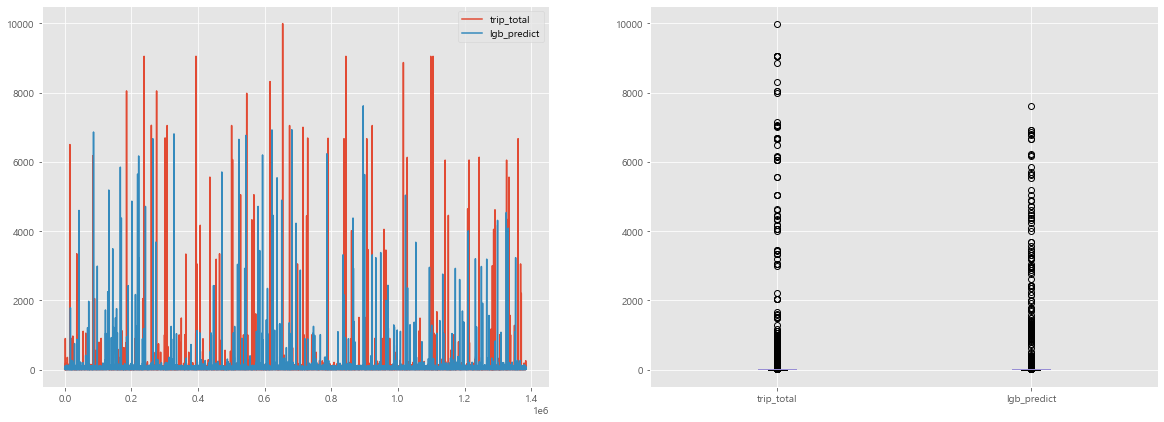

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
data[['trip_total', 'lgb_predict']].plot(ax=ax[0])
data[['trip_total', 'lgb_predict']].boxplot(ax=ax[1])

- 예측 결과를 보면 모델이 정확하게 예측하지 못하는 것으로 보인다.

# Target 변수를 fare로 변경하고 진행

In [54]:
X_cols = list(data.columns)
X_cols.remove('fare')

In [55]:
X = data[X_cols]
y = data['fare']

In [56]:
# Scaling

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
#y = y_scaler.fit_transform(y.values.reshape(-1,1))

In [57]:
# Train, Test splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [58]:
print('Train Set : ', X_train.shape)
print('Test Set : ', X_test.shape)

Train Set :  (968826, 7)
Test Set :  (415212, 7)


### Light Gradient Boosting Machine

In [59]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [60]:
params = {
            'learning_rate' : 0.01,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [61]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 30.8069
[200]	valid_0's rmse: 26.1856
[300]	valid_0's rmse: 25.0554
[400]	valid_0's rmse: 24.8732
Early stopping, best iteration is:
[396]	valid_0's rmse: 24.8678


In [62]:
# 예측
pred = model.predict(X_test)

In [63]:
pred

array([15.50124573,  7.47817227, 10.92974949, ...,  6.98795793,
        5.12353502,  6.52888376])

In [64]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    model.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    model.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
lgb_predict = X_train_predict.append(X_test_predict)

In [65]:
lgb_predict[:5]

,predict
0,8.094112
1,6.352457
2,17.829008
3,9.679757
4,41.259098


In [66]:
data['lgb_predict'] = lgb_predict.values

In [67]:
data

,trip_seconds,fare,tips,tolls,extras,trip_km,trip_total,lgb_predict
0,180.0,4.50,0.00,0.0,0.0,0.643700,4.50,8.094112
1,480.0,7.00,0.00,0.0,0.0,1.770300,7.00,6.352457
2,1080.0,17.75,0.00,0.0,0.0,9.977900,17.75,17.829008
3,60.0,3.75,0.00,0.0,0.0,0.321900,3.75,9.679757
4,180.0,5.00,2.00,0.0,1.5,1.001646,8.50,41.259098
...,...,...,...,...,...,...,...,...
1384033,540.0,12.25,2.45,0.0,0.0,0.321900,14.70,5.155496
1384034,840.0,10.25,0.00,0.0,0.0,3.862400,10.25,4.855151
1384035,1380.0,44.00,5.00,0.0,0.0,28.807300,49.00,6.987958
1384036,960.0,11.75,0.00,0.0,1.0,4.023400,12.75,5.123535


### Random Forest Feature Selection

In [44]:
X = data[X_cols]
y = data['trip_total']

In [45]:
# Train, Test splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [47]:
# parameter 설정
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [50]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(20)

,Feature,Importance
1,fare,0.599
4,extras,0.395
2,tips,0.003
0,trip_seconds,0.001
5,trip_km,0.001
3,tolls,0.001


In [51]:
new_importance = df_importance[df_importance['Importance'] > 0.01]

In [52]:
new_importance

,Feature,Importance
1,fare,0.599192
4,extras,0.395286


Text(0, 0.5, '변수')

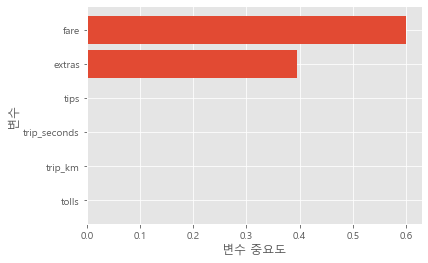

In [53]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(15)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

### Light Gradient Boosting Machine After Feature Select 

In [73]:
data.columns

Index(['trip_seconds', 'fare', 'tips', 'tolls', 'extras', 'trip_km',
       'trip_total', 'lgb_predict'],
      dtype='object')

In [74]:
X_cols = ['fare', 'extras']

In [75]:
X = data[X_cols]
y = data['trip_total']

In [76]:
# Scaling

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
#y = y_scaler.fit_transform(y.values.reshape(-1,1))

In [77]:
# Train, Test splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [78]:
print('Train Set : ', X_train.shape)
print('Test Set : ', X_test.shape)

Train Set :  (968826, 2)
Test Set :  (415212, 2)


In [79]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [80]:
params = {
            'learning_rate' : 0.01,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

In [81]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 33.826
[200]	valid_0's rmse: 27.7043
[300]	valid_0's rmse: 25.6923
[400]	valid_0's rmse: 24.8845
[500]	valid_0's rmse: 24.4122
[600]	valid_0's rmse: 24.2656
[700]	valid_0's rmse: 24.1756
[800]	valid_0's rmse: 24.0758
[900]	valid_0's rmse: 23.9998
[1000]	valid_0's rmse: 23.9788
[1100]	valid_0's rmse: 23.9523
[1200]	valid_0's rmse: 23.92
[1300]	valid_0's rmse: 23.8891
[1400]	valid_0's rmse: 23.8666
[1500]	valid_0's rmse: 23.8493
[1600]	valid_0's rmse: 23.8341
[1700]	valid_0's rmse: 23.8216
[1800]	valid_0's rmse: 23.8194
[1900]	valid_0's rmse: 23.8189
Early stopping, best iteration is:
[1859]	valid_0's rmse: 23.8163


In [82]:
# 예측
pred = model.predict(X_test)

In [83]:
pred

array([ 9.57556691,  9.87531459, 53.20332389, ...,  7.01136171,
        6.34869196,  7.01136171])

In [84]:
np.sqrt(mean_squared_error(y_test,pred))

23.816269755452876

In [85]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    model.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    model.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
lgb_predict = X_train_predict.append(X_test_predict)

In [86]:
lgb_predict[:5]

,predict
0,15.147927
1,11.678396
2,42.398954
3,6.170315
4,14.565228


In [87]:
data['lgb_predict'] = lgb_predict.values

In [88]:
data

,trip_seconds,fare,tips,tolls,extras,trip_km,trip_total,lgb_predict
0,180.0,4.50,0.00,0.0,0.0,0.643700,4.50,15.147927
1,480.0,7.00,0.00,0.0,0.0,1.770300,7.00,11.678396
2,1080.0,17.75,0.00,0.0,0.0,9.977900,17.75,42.398954
3,60.0,3.75,0.00,0.0,0.0,0.321900,3.75,6.170315
4,180.0,5.00,2.00,0.0,1.5,1.001646,8.50,14.565228
...,...,...,...,...,...,...,...,...
1384033,540.0,12.25,2.45,0.0,0.0,0.321900,14.70,56.706585
1384034,840.0,10.25,0.00,0.0,0.0,3.862400,10.25,7.279975
1384035,1380.0,44.00,5.00,0.0,0.0,28.807300,49.00,7.011362
1384036,960.0,11.75,0.00,0.0,1.0,4.023400,12.75,6.348692


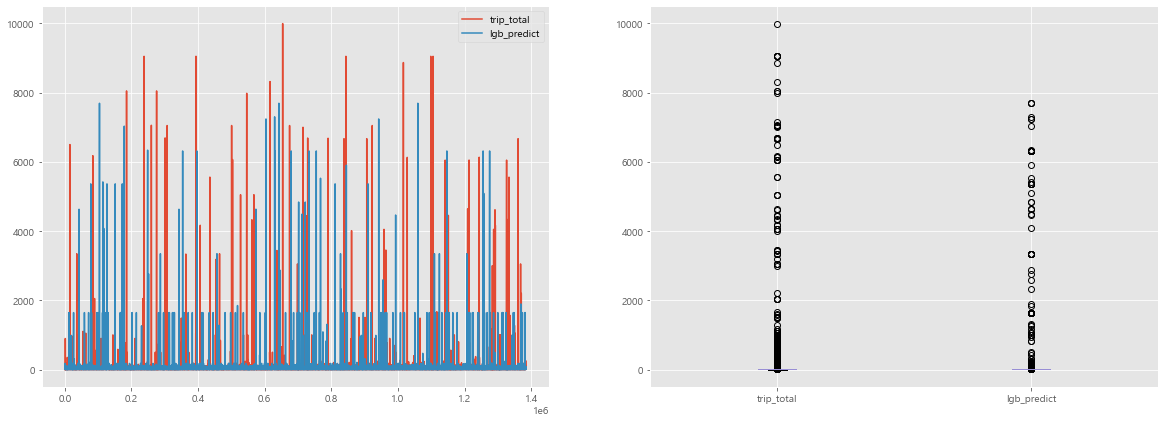

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
data[['trip_total', 'lgb_predict']].plot(ax=ax[0])
data[['trip_total', 'lgb_predict']].boxplot(ax=ax[1])

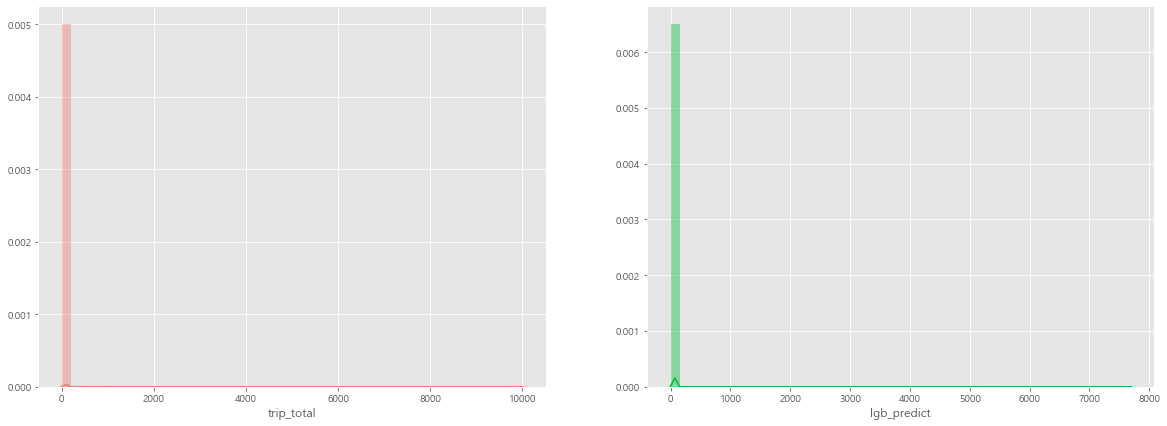

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.distplot(data['trip_total'], ax=ax[0], color=color_pal[0])
sns.distplot(data['lgb_predict'], ax=ax[1], color=color_pal[3])